### TonEd Notebook

In [1]:
#import our stuff here
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, math, os, random
%matplotlib inline
import librosa.display as display
from IPython.display import Audio
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree, linear_model
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from collections import Counter


In [2]:
def extract_features(audio, sr):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr)[1:14, :]
    mean_mfccs = np.mean(mfccs, axis = 1)
    var_mfccs = np.var(mfccs, axis = 1)
    delta_mfccs = np.diff(mfccs, axis = 1)
    mean_delta_mfccs = np.mean(delta_mfccs, axis = 1)
    var_delta_mfccs = np.var(delta_mfccs, axis = 1)
    #return np.concatenate([var_mfccs, var_delta_mfccs])
    return np.concatenate([mean_mfccs, var_mfccs, mean_delta_mfccs, var_delta_mfccs])
    
def analyze_results(results):
    true_positives = sum([r[0] == r[1] for r in results])
    false_positives = sum([r[0] != r[1] for r in results])
    precision = true_positives / float(true_positives + false_positives)
    return precision

def print_results(method, results):
    print "~~~ " + method + " Results ~~~"
    print "Precision: " + str(analyze_results(results))
    print "Confusion matrix:"
    print confusion_matrix([r[0] for r in results], [r[1] for r in results])
    print ""
    
def features_by_name(name):
    fullstr = "samples/" + name + "_Full.wav"
    crunchystr = "samples/" + name + "_Crunchy.wav"
    thinstr = "samples/" + name + "_Thin.wav"
    pathstrings = [fullstr, thinstr, crunchystr]
    
    features = []
    classes = []
    for path in pathstrings:
        if (path.endswith("Full.wav")):
            tone = "Full"
        elif (path.endswith("Crunchy.wav")):
            tone = "Crunchy"
        elif (path.endswith("Thin.wav")):
            tone = "Thin"
        sr = 44100.
        sample, sr = librosa.load(path, sr)
        frames = librosa.util.frame(sample, 26460, hop_length = 26460)
        for frame in range(frames.shape[-1]):
            feature = extract_features(frames[:, frame], sr)
            features.append(feature)
            classes.append(tone)
            
    return features, classes

def features_by_file(path):
    features = []
    sr = 44100.
    sample, sr = librosa.load(path, sr)
    frames = librosa.util.frame(sample, 26460, hop_length = 26460)
    for frame in range(frames.shape[-1]):
            feature = extract_features(frames[:, frame], sr)
            features.append(feature)
            
    return features

def features_by_tone(tone):
    features = []
    classes = []
    for file in os.listdir("samples/"):
        if file.endswith(tone + ".wav"):
            sr = 44100.
            pathstr = os.path.join("samples/", file)
            sample, sr = librosa.load(pathstr, sr)
            frames = librosa.util.frame(sample, 26460, hop_length = 26460)
            for frame in range(frames.shape[-1]):
                feature = extract_features(frames[:, frame], sr)
                features.append(feature)
                classes.append(tone)
    
    return features, classes

def cross_validation(features, classes, model, folds):
    results = []
    for i in range(folds):
        start = i*all_features.shape[0]/folds
        stop = (i+1)*all_features.shape[0]/folds
        cross_validation_set = np.concatenate((all_features[0:start, :], all_features[stop:, :]))
        cross_validation_classes = np.concatenate((all_classes[0:start], all_classes[stop:]))

        if model == "SVM":
            clf = sklearn.svm.SVC()
        elif model == "Nearest Neighbor":
            clf = KNeighborsClassifier(n_neighbors=15, algorithm='auto')
        elif model == "Decision Tree":
            clf = tree.DecisionTreeClassifier()
        elif model == "Stochastic Gradient Descent":
            clf = linear_model.SGDClassifier()
        elif model == "Multi-layer Perceptron":
            clf = MLPClassifier()
        else:
            print model +" is not a valid model."
            return
        
        clf.fit(cross_validation_set, cross_validation_classes)  
        for j in range(start, stop):        
            result = clf.predict(all_features[j, :].reshape(1, -1))
            results.append((all_classes[j], result))

    print_results(model, results)
    
def run_model(train_features, train_classes, test_features, model):
    results = []
    if model == "SVM":
        clf = sklearn.svm.SVC()
    elif model == "Nearest Neighbor":
        clf = KNeighborsClassifier(n_neighbors=15, algorithm='auto')
    elif model == "Decision Tree":
        clf = tree.DecisionTreeClassifier()
    elif model == "Stochastic Gradient Descent":
        clf = linear_model.SGDClassifier()
    elif model == "Multi-layer Perceptron":
        clf = MLPClassifier()
    else:
        print model +" is not a valid model."
        return

    clf.fit(train_features, train_classes)
    for feature in test_features:
        result = clf.predict(feature.reshape(1,-1))
        results.append(result[0])
    
    return results

def print_most_common_class(results, expected):
    data = Counter(results)
    most_common = data.most_common(1)
    print "The most common class was " + most_common[0][0] + " (Predicted " + str(most_common[0][1]) + " times, " +  str(len(results)) + " total)."
    print "The expected class was " + expected + "."
    print ""

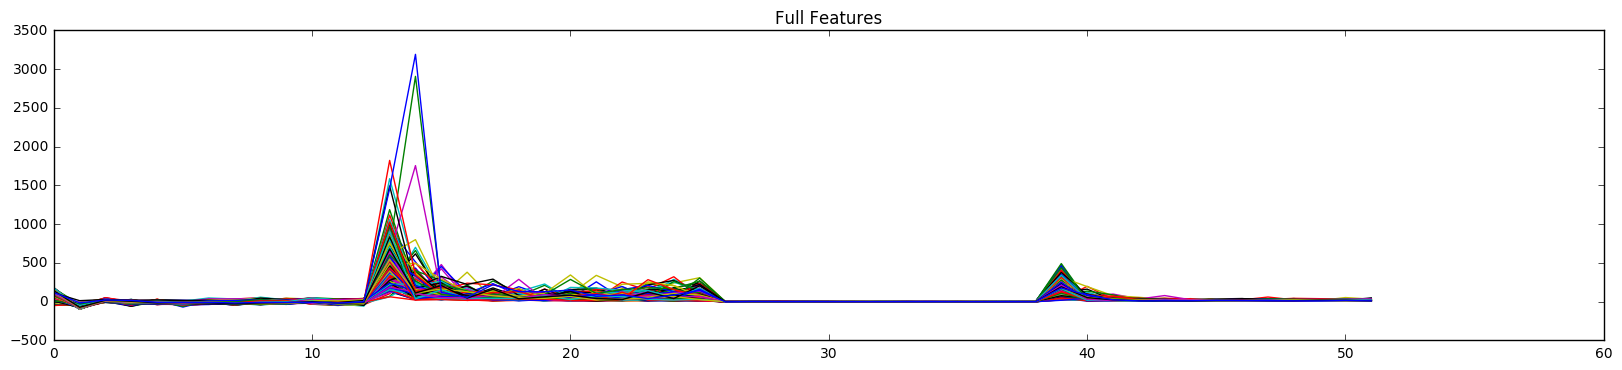

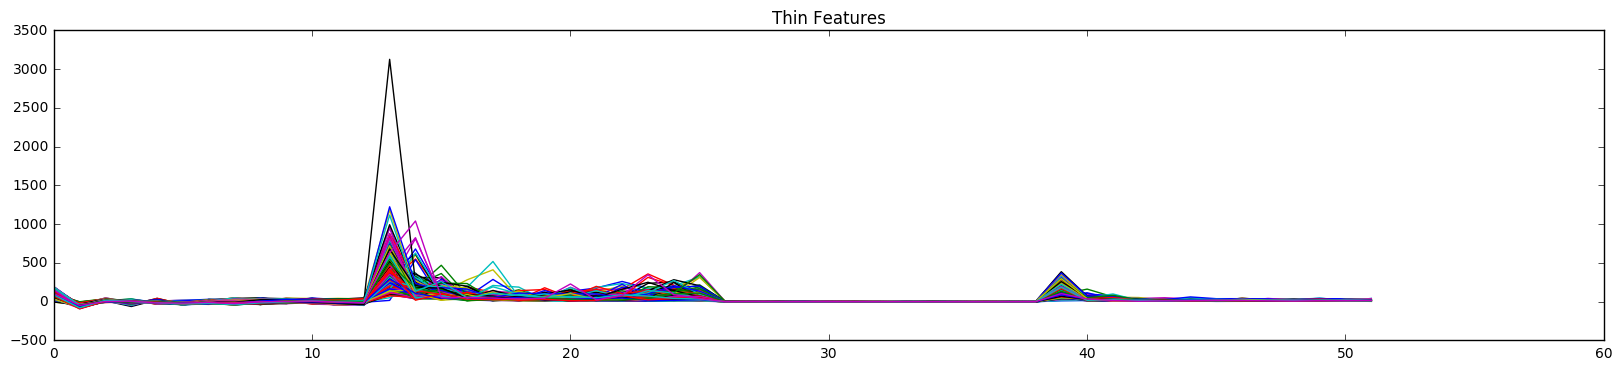

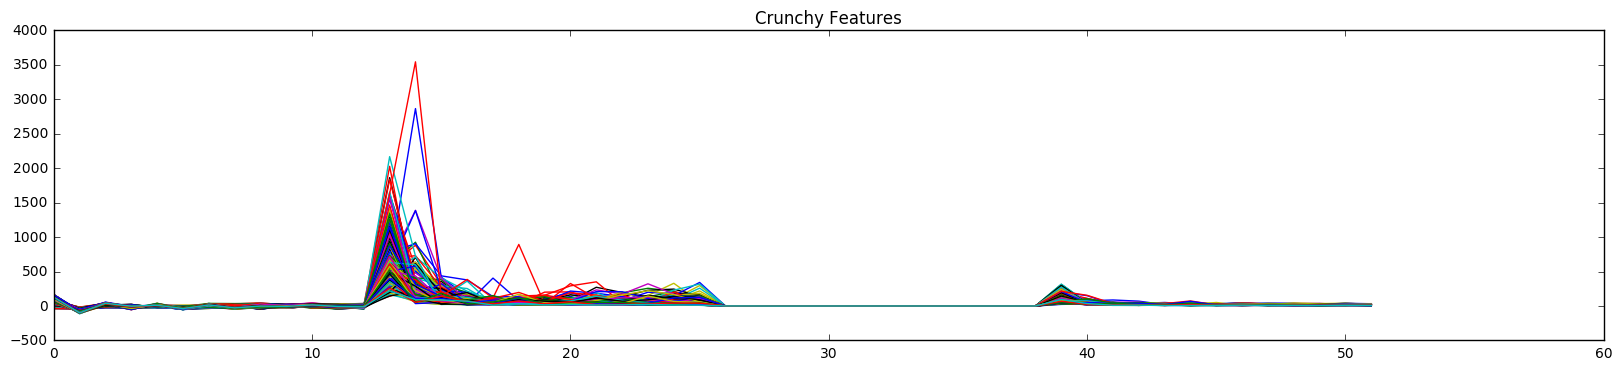

~~~ Decision Tree Results ~~~
Precision: [ 0.54126679]
Confusion matrix:
[[105  42  25]
 [ 54  78  44]
 [ 29  45  99]]

~~~ Nearest Neighbor Results ~~~
Precision: [ 0.51247601]
Confusion matrix:
[[119  35  18]
 [ 69  65  42]
 [ 36  54  83]]

~~~ Stochastic Gradient Descent Results ~~~
Precision: [ 0.47216891]
Confusion matrix:
[[102  34  36]
 [ 58  57  61]
 [ 39  47  87]]

~~~ Multi-layer Perceptron Results ~~~
Precision: [ 0.52399232]
Confusion matrix:
[[110  34  28]
 [ 49  80  47]
 [ 29  61  83]]



In [3]:
#get full features
full_features, full_classes = features_by_tone("Full")
plt.figure(figsize=(20, 4))
for feat in full_features:
    plt.plot(feat)
    plt.title("Full Features")
plt.show()

#get thin features
thin_features, thin_classes = features_by_tone("Thin")
plt.figure(figsize=(20, 4))
for feat in thin_features:
    plt.plot(feat)
    plt.title("Thin Features")
plt.show()

#get crunchy features
crunchy_features, crunchy_classes = features_by_tone("Crunchy")
plt.figure(figsize=(20, 4))
for feat in crunchy_features:
    plt.plot(feat)
    plt.title("Crunchy Features")
plt.show()

#concatenate all features together
all_features = np.concatenate([full_features, thin_features, crunchy_features])
all_classes = np.concatenate([full_classes, thin_classes, crunchy_classes])
#shuffle the order!!
all_features, all_classes = shuffle(all_features, all_classes)

#run different models
cross_validation(all_features, all_classes, "Decision Tree", 18)
cross_validation(all_features, all_classes, "Nearest Neighbor", 18)
cross_validation(all_features, all_classes, "Stochastic Gradient Descent", 18)
#cross_validation(all_features, all_classes, "SVM", 18)
cross_validation(all_features, all_classes, "Multi-layer Perceptron", 18)


In [4]:
## Let's classify some specific scales now...

#get features by name
emily_features, emily_classes = features_by_name("EmilyOtt")
jon_features, jon_classes = features_by_name("JonHuang")
megan_features, megan_classes = features_by_name("MeganRenner")
ann_features, ann_classes = features_by_name("AnnDuchow")
kaitlin_features, kaitlin_classes = features_by_name("KaitlinMoran")
matt_features, matt_classes = features_by_name("MatthewNiemer")

#concatenate all features together (leave mine out)
all_features = np.concatenate([emily_features, megan_features, ann_features, jon_features, kaitlin_features])
all_classes = np.concatenate([emily_classes, megan_classes, ann_classes, jon_classes, kaitlin_classes])
#shuffle the order!!
all_features, all_classes = shuffle(all_features, all_classes)

#get each scale that I played
full_features = features_by_file('samples/MatthewNiemer_Full.wav')
crunchy_features = features_by_file('samples/MatthewNiemer_Crunchy.wav')
thin_features = features_by_file('samples/MatthewNiemer_Thin.wav')

#full_results = run_model(all_features, all_classes, full_features, "Nearest Neighbor")
#crunchy_results = run_model(all_features, all_classes, crunchy_features, "Nearest Neighbor")
#thin_results = run_model(all_features, all_classes, thin_features , "Nearest Neighbor")
full_results = run_model(all_features, all_classes, full_features, "Decision Tree")
crunchy_results = run_model(all_features, all_classes, crunchy_features, "Decision Tree")
thin_results = run_model(all_features, all_classes, thin_features , "Decision Tree")
print_most_common_class(full_results, "Full")
print_most_common_class(crunchy_results, "Crunchy")
print_most_common_class(thin_results, "Thin")

The most common class was Crunchy (Predicted 15 times, 31 total).
The expected class was Full.

The most common class was Crunchy (Predicted 26 times, 30 total).
The expected class was Crunchy.

The most common class was Full (Predicted 14 times, 29 total).
The expected class was Thin.



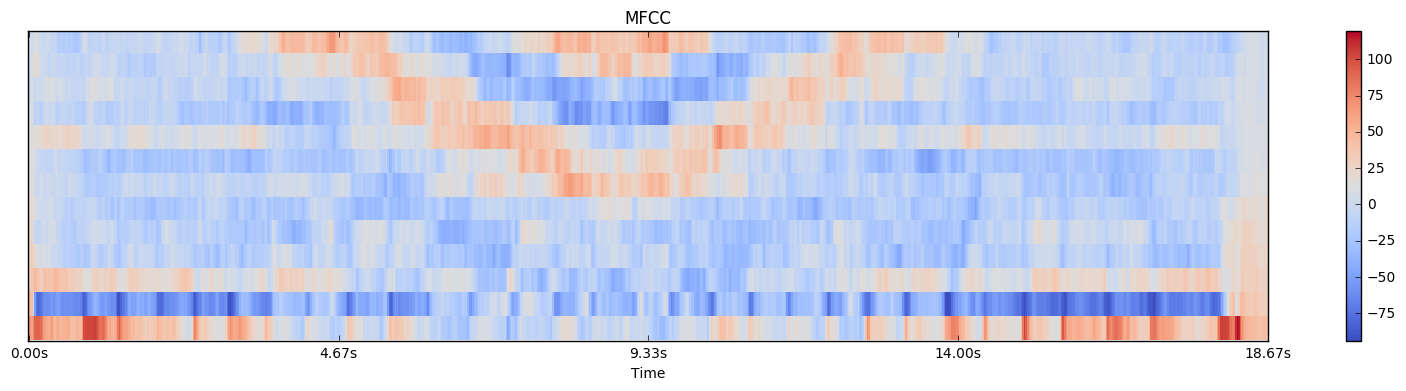

In [7]:
sr = 44100.
sample, sr = librosa.load("samples/MatthewNiemer_Full.wav")
mfccs = librosa.feature.mfcc(y=sample, sr=sr)[1:14, :]
plt.figure(figsize=(20, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

In [8]:
def plot_audio(x, sr, figsize=(16,4)):
    """
    A simple audio plotting function
    
    Parameters
    ----------
    x: np.ndarray
        Audio signal to plot
    sr: int
        Sample rate
    figsize: tuple
        A duple representing the figure size (xdim,ydim)
    """
    length = float(x.shape[0]) / sr
    t = np.linspace(0,length,x.shape[0])
    plt.figure(figsize=figsize)
    plt.plot(t, x)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.show()

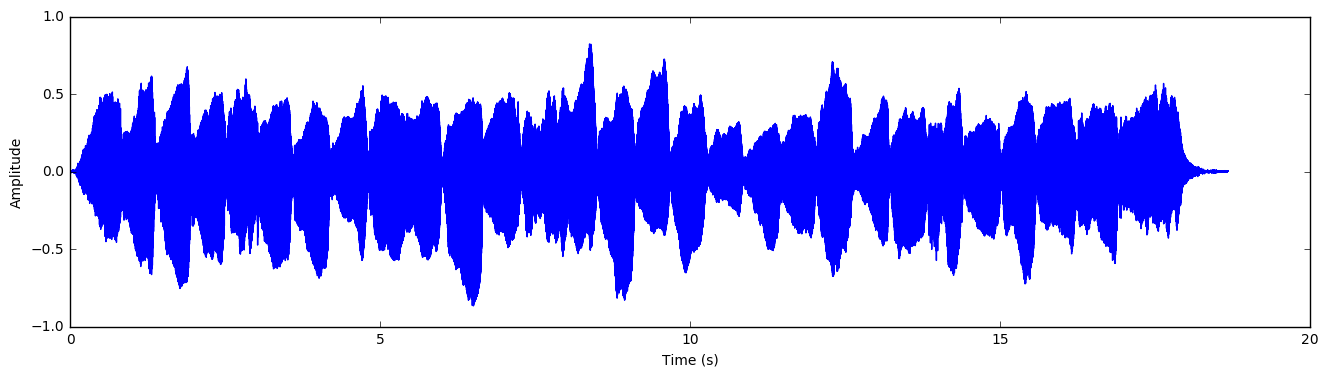

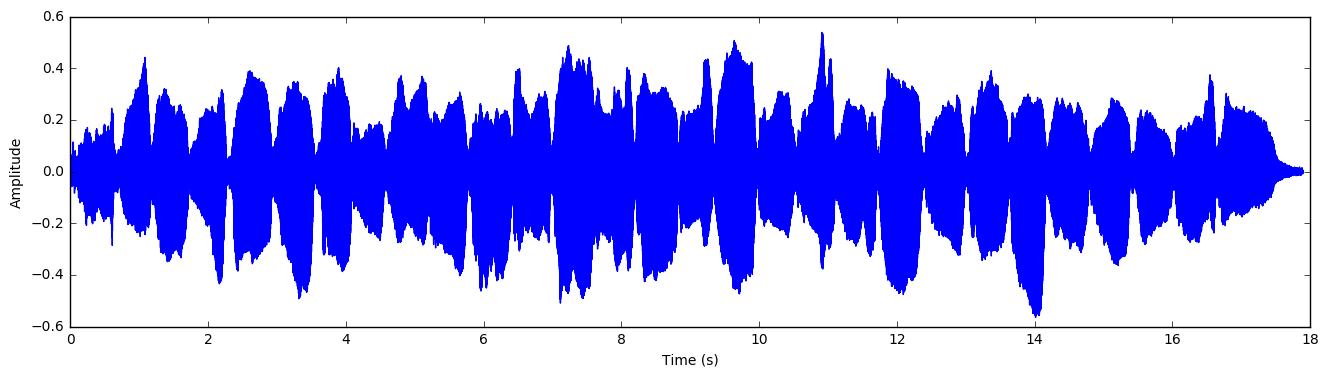

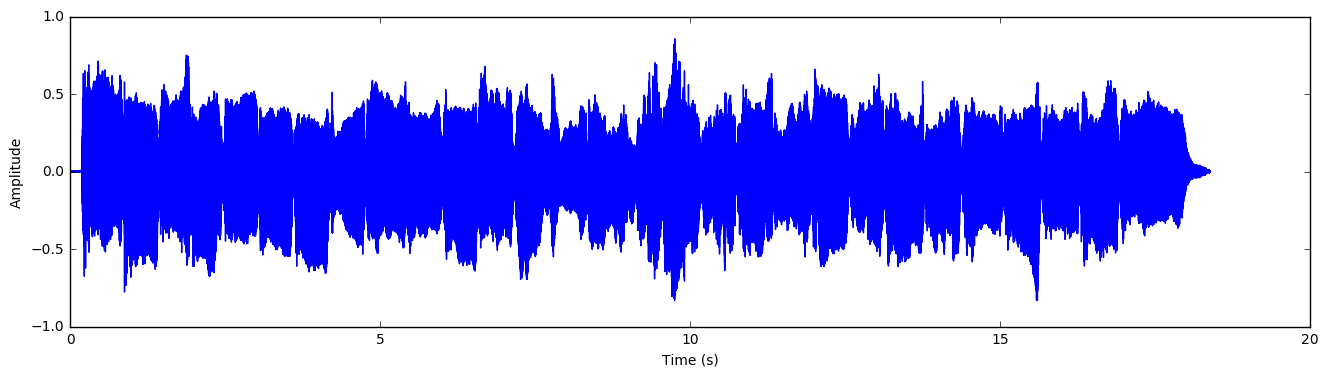

In [9]:
sr = 44100.
full, sr = librosa.load("samples/MatthewNiemer_Full.wav")
thin, sr = librosa.load("samples/MatthewNiemer_Thin.wav")
crunchy, sr = librosa.load("samples/MatthewNiemer_Crunchy.wav")
plot_audio(full, sr)
plot_audio(thin, sr)
plot_audio(crunchy, sr)